In [1]:
import torch
from torch import nn
from numba import jit
import torchvision
from matplotlib import pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
device = "cuda:0" if torch.cuda.is_available() else "cpu"
plt.style.use("dark_paper")

In [2]:
#transform = torchvision.transforms.Pad((280,280))
imagenet_data_train = torchvision.datasets.MNIST("./data/",train=True) #transform=
imagenet_data_val = torchvision.datasets.MNIST("./data/",train=False)

In [3]:
torch.randint(0,10,(1,)).item()

3

In [4]:
@torch.jit.script
def augment(imgs):
    nums = []
    for img in imgs:
        i = torch.randint(0,10,(1,)).item()
        j = torch.randint(0,10,(1,)).item()
        istart = i * 28
        iend = (i+1) * 28
        jstart = i * 28
        jend = (i+1) * 28
        zeros = torch.zeros(280, 280)
        zeros[istart:iend, jstart:jend] = img
        nums.append(zeros)
    return torch.stack(nums)

In [5]:
# Pick some example digits and put them in a 10 by 10 grid (280x280) images
nums = augment(imagenet_data_train.data)
trainset = torch.utils.data.TensorDataset(
    nums.unsqueeze(1), imagenet_data_train.targets)
# Pick some example digits and put them in a 10 by 10 grid (280x280) images
nums = augment(imagenet_data_val.data)
valset = torch.utils.data.TensorDataset(
    nums.unsqueeze(1), imagenet_data_val.targets)
del imagenet_data_train, imagenet_data_val

# Data
The validation set is made of digits located somewhere in a 10x10 grid. The training data, on the otherhand, is always located in the top left corner.

Text(0.5, 0.91, 'Validation')

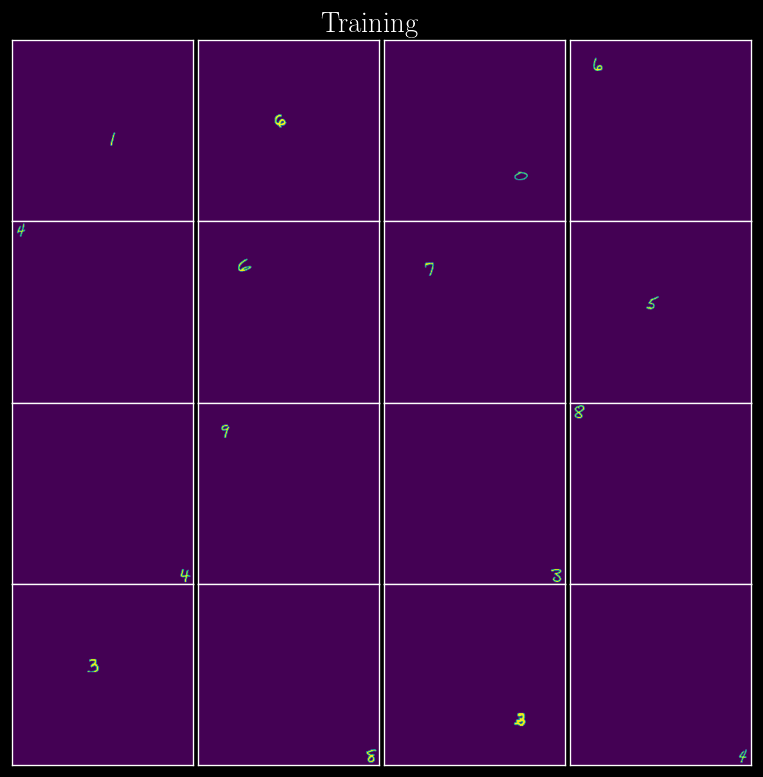

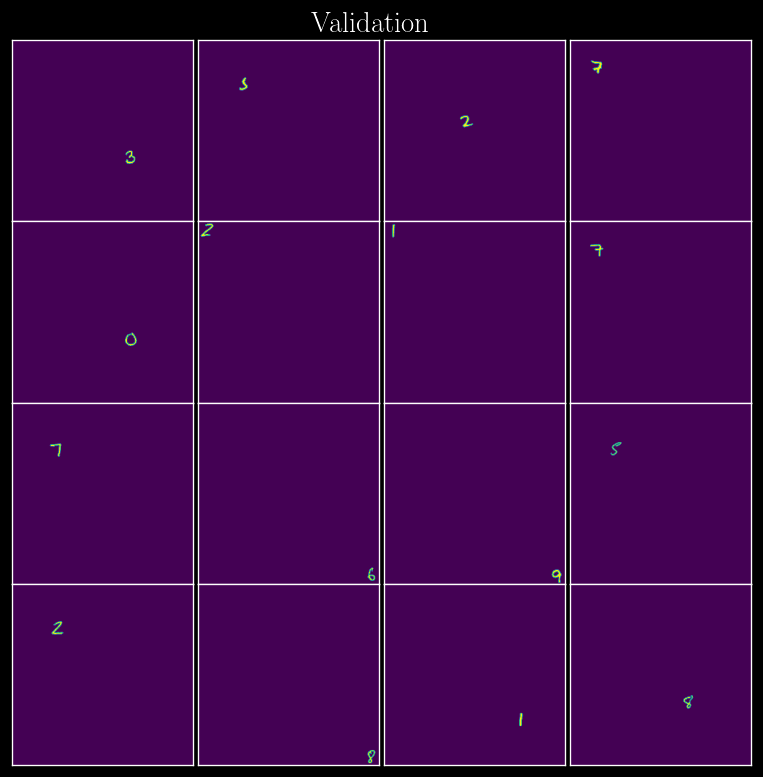

In [7]:
fig, axes = plt.subplots(4,4,sharex=True,sharey=True,figsize=(8,8),dpi=120)
for i,ax in zip(np.random.randint(0,len(trainset),size=16),axes.flatten()):
    ax.imshow(trainset[i][0][0])
    ax.set_xticks([])
    ax.set_yticks([])
plt.subplots_adjust(hspace=0,wspace=0)
fig.suptitle("Training",y=.91)

fig, axes = plt.subplots(4,4,sharex=True,sharey=True,figsize=(8,8),dpi=120)
for i,ax in zip(np.random.randint(0,len(valset),size=16),axes.flatten()):
    ax.imshow(valset[i][0][0])
    ax.set_xticks([])
    ax.set_yticks([])
plt.subplots_adjust(hspace=0,wspace=0)
fig.suptitle("Validation",y=.91)

In [8]:
fcn = torch.nn.Sequential(torch.nn.Flatten(),
                          torch.nn.Linear(280*280,1024),
                          torch.nn.ReLU(),
                          torch.nn.Linear(1024,10))
fcn.to(device)
cnn = torch.nn.Sequential(torch.nn.Conv2d(1,1024,kernel_size=28,stride=28),
                          torch.nn.BatchNorm2d(1024),
                          torch.nn.ReLU(),
                          torch.nn.MaxPool2d((10,10)),
                          torch.nn.Flatten(),
                          torch.nn.Linear(1024,10)) #(10)**2
cnn.to(device)
criterion = torch.nn.CrossEntropyLoss()

# Training some models 

In [9]:
T = 10 #epochs
batch_size = 20 
log_step = 1 # validate and print losses every log_steps

trainloader = torch.utils.data.DataLoader(trainset,
                                          batch_size=batch_size,
                                          shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size)

In [10]:
# Define training and validation functions
def train(model,x,y):
    x = x.to(device)
    y = y.to(device)
    model.train()
    yhat = model(x)
    loss = criterion(yhat,y)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return loss.item()
def validate(model,x,y):
    x = x.to(device)
    y = y.to(device)
    model.eval()
    with torch.no_grad():
        yhat = model(x)
        loss = criterion(yhat,y)
        return loss.item()

In [16]:
# Define metrics function
def metrics(model):
    with torch.no_grad():
        model.eval()
        model.to(device)
        yhat = []
        for x,y in valloader:
            x = x.to(device)
            yhat.append(model(x).cpu().numpy())
    yhat = np.concatenate(yhat)
    out = classification_report(valset.tensors[1],yhat.argmax(axis=1))
    print(out)
def plot_loss():
    plt.plot(np.arange(0,T),losses_train[0:],label="Train")
    plt.plot(np.arange(0,T,log_step),losses_val,label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

#  CNN Training

In [12]:
# Train the CNN for 100 epochs 
optimizer = torch.optim.Adam(cnn.parameters(),lr=1e-2)
losses_train = []
losses_val = []
cnn.train()
total_steps = len(trainloader)
for t in range(1,T+1):
    loss = list() # Combine losses from differetn steps in a single epoch
    # Training Step
    for step,(x,y) in enumerate(trainloader):
        loss_ = train(cnn,x,y)
        loss.append(loss_)
        print(f"Epoch {t:>03d}/{T:^3d} [Step {step+1}/{total_steps}] | Training loss: {loss_:^.4f}", end="\r")
    loss = np.mean(loss)
    losses_train.append(loss)
    # Validation Step
    if t%log_step == 0:
        message = f"Epoch {t:>03d}/{T:^3d} | Training loss: {loss:^.4f} - "
        loss = []
        with torch.no_grad():
            for x,y in valloader:
                loss_ = validate(cnn,x,y)
                loss.append(loss_)
        loss = np.mean(loss)
        losses_val.append(loss)
        message += f"Validation loss: {loss:^.4f}"
        print(message) #,end="\r"

Epoch 001/10  | Training loss: 0.5394 - Validation loss: 0.1308
Epoch 002/10  | Training loss: 0.1657 - Validation loss: 0.1352
Epoch 003/10  | Training loss: 0.1279 - Validation loss: 0.1265
Epoch 004/10  | Training loss: 0.1095 - Validation loss: 0.0880
Epoch 005/10  | Training loss: 0.0954 - Validation loss: 0.1003
Epoch 006/10  | Training loss: 0.0830 - Validation loss: 0.0999
Epoch 007/10  | Training loss: 0.0771 - Validation loss: 0.0989
Epoch 008/10  | Training loss: 0.0697 - Validation loss: 0.0870
Epoch 009/10  | Training loss: 0.0653 - Validation loss: 0.1271
Epoch 010/10  | Training loss: 0.0578 - Validation loss: 0.1063


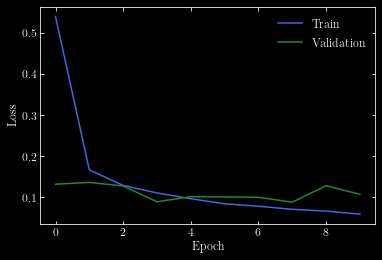

              precision    recall  f1-score   support

           0       0.93      1.00      0.96        53
           1       1.00      1.00      1.00        73
           2       0.97      0.97      0.97        64
           3       0.98      0.97      0.98        62
           4       0.97      0.97      0.97        67
           5       0.95      0.96      0.96        56
           6       1.00      0.94      0.97        52
           7       0.98      0.98      0.98        57
           8       0.91      0.94      0.92        52
           9       0.97      0.92      0.94        64

    accuracy                           0.97       600
   macro avg       0.97      0.97      0.97       600
weighted avg       0.97      0.97      0.97       600



In [17]:
plot_loss()
metrics(cnn)

# LCN Training

In [18]:
from Models import LCN

In [19]:
lcn = LCN()
lcn.to(device)

LCN(
  (activation): ReLU(inplace=True)
  (decoder): Linear(in_features=1000, out_features=10, bias=True)
)

In [20]:
# Train the lcn for 100 epochs 
optimizer = torch.optim.Adam(lcn.parameters(),lr=1e-2)
losses_train = []
losses_val = []
lcn.train()
total_steps = len(trainloader)
for t in range(1,T+1):
    loss = list() # Combine losses from differetn steps in a single epoch
    # Training Step
    for step,(x,y) in enumerate(trainloader):
        loss_ = train(lcn,x,y)
        loss.append(loss_)
        print(f"Epoch {t:>03d}/{T:^3d} [Step {step+1}/{total_steps}] | Training loss: {loss_:^.4f}", end="\r")
    loss = np.mean(loss)
    losses_train.append(loss)
    # Validation Step
    if t%log_step == 0:
        message = f"Epoch {t:>03d}/{T:^3d} | Training loss: {loss:^.4f} - "
        loss = []
        with torch.no_grad():
            for x,y in valloader:
                loss_ = validate(lcn,x,y)
                loss.append(loss_)
        loss = np.mean(loss)
        losses_val.append(loss)
        message += f"Validation loss: {loss:^.4f}"
        print(message) #,end="\r"

Epoch 001/10  | Training loss: 4.2257 - Validation loss: 2.2967
Epoch 002/10  | Training loss: 2.3277 - Validation loss: 2.3091
Epoch 003/10  | Training loss: 2.3072 - Validation loss: 2.4158
Epoch 004/10  | Training loss: 2.3039 - Validation loss: 2.3023
Epoch 005/10  | Training loss: 2.3019 - Validation loss: 2.3015
Epoch 006/10  | Training loss: 2.3022 - Validation loss: 2.3038
Epoch 007/10  | Training loss: 2.3018 - Validation loss: 2.3019
Epoch 008/10  | Training loss: 2.3021 - Validation loss: 2.3017
Epoch 009/10  | Training loss: 2.3019 - Validation loss: 2.3041
Epoch 010/10  | Training loss: 2.3019 - Validation loss: 2.3034


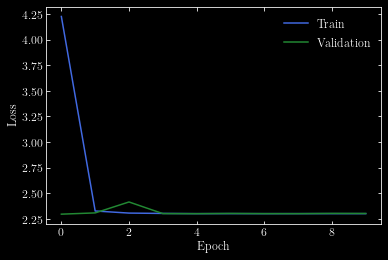

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        53
           1       0.00      0.00      0.00        73
           2       0.00      0.00      0.00        64
           3       0.10      1.00      0.19        62
           4       0.00      0.00      0.00        67
           5       0.00      0.00      0.00        56
           6       0.00      0.00      0.00        52
           7       0.00      0.00      0.00        57
           8       0.00      0.00      0.00        52
           9       0.00      0.00      0.00        64

    accuracy                           0.10       600
   macro avg       0.01      0.10      0.02       600
weighted avg       0.01      0.10      0.02       600



/home/kitouni/anaconda3/envs/gnn/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [21]:
plot_loss()
metrics(lcn)

# FCN Training

In [22]:
# Train the FCN for 100 epochs 
optimizer = torch.optim.Adam(fcn.parameters(),lr=1e-2)
losses_train = []
losses_val = []
fcn.train()
total_steps = len(trainloader)
for t in range(1,T+1):
    loss = list() # Combine losses from differetn steps in a single epoch
    # Training Step
    for step,(x,y) in enumerate(trainloader):
        loss_ = train(fcn,x,y)
        loss.append(loss_)
        print(f"Epoch {t:>03d}/{T:^3d} [Step {step+1}/{total_steps}] | Training loss: {loss_:^.4f}", end="\r")
    loss = np.mean(loss)
    losses_train.append(loss)
    # Validation Step
    if t%log_step == 0:
        message = f"Epoch {t:>03d}/{T:^3d} | Training loss: {loss:^.4f} - "
        loss = []
        with torch.no_grad():
            for x,y in valloader:
                loss_ = validate(fcn,x,y)
                loss.append(loss_)
        loss = np.mean(loss)
        losses_val.append(loss)
        message += f"Validation loss: {loss:^.4f}"
        print(message) #,end="\r"

Epoch 001/10  | Training loss: 9.0761 - Validation loss: 2.8171
Epoch 002/10  | Training loss: 2.9637 - Validation loss: 2.3052
Epoch 003/10  | Training loss: 2.5172 - Validation loss: 2.2929
Epoch 004/10  | Training loss: 2.3277 - Validation loss: 2.3980
Epoch 005/10  | Training loss: 2.3229 - Validation loss: 2.3147
Epoch 006/10  | Training loss: 2.2994 - Validation loss: 2.3260
Epoch 007/10  | Training loss: 2.3199 - Validation loss: 2.3082
Epoch 008/10  | Training loss: 2.3033 - Validation loss: 2.3131
Epoch 009/10  | Training loss: 2.3046 - Validation loss: 2.3283
Epoch 010/10  | Training loss: 2.3504 - Validation loss: 2.3380


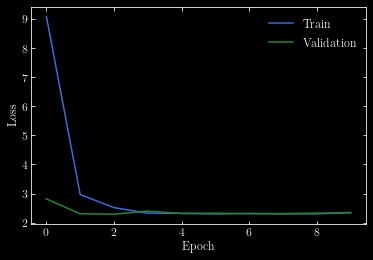

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        53
           1       0.67      0.03      0.05        73
           2       0.00      0.00      0.00        64
           3       0.00      0.00      0.00        62
           4       0.11      0.99      0.20        67
           5       0.00      0.00      0.00        56
           6       0.00      0.00      0.00        52
           7       0.00      0.00      0.00        57
           8       0.00      0.00      0.00        52
           9       0.00      0.00      0.00        64

    accuracy                           0.11       600
   macro avg       0.08      0.10      0.03       600
weighted avg       0.09      0.11      0.03       600



/home/kitouni/anaconda3/envs/gnn/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [23]:
plot_loss()
metrics(fcn)